# Packages

In [1]:
! pip install --quiet pythainlp

In [2]:
! pip install --upgrade gensim

In [3]:
import pandas as pd
import re
# from nltk.tokenize import word_tokenize
from pythainlp.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

# Cleaning Data

In [4]:
pos_df = pd.read_csv('pos.csv')
neg_df = pd.read_csv('neg.csv')

In [5]:
neg_df.head()

,Sentence,Category
0,จะต้องเสียเธอไป,neg
1,รู้บ้างไหมว่าเจ็บแค่ไหน,neg
2,จะได้พร้อมทำใจ รอให้เธอบอก,neg
3,ไม่ชอบเลย,neg
4,เมื่อเธอเจ็บจากเขามา,neg


In [6]:
pos_df.shape

(250, 2)

In [7]:
neg_df.shape

(250, 2)

In [8]:
sentiment_df = pd.concat([neg_df, pos_df])
sentiment_df.shape

(500, 2)

In [9]:
def cleaning(sentences):
    words = []
    temp = []
    for s in sentences:
        clean = re.sub(r'^[ก-๙]', '', s)
        w = word_tokenize(clean)
        temp.append([i.lower() for i in w])
        words.append(' '.join(w).lower())
    return words, temp

In [10]:
cleaned_words, temp = cleaning(sentiment_df.Sentence.values)
print(cleaned_words[0])

ะ ต้อง เสีย เธอ ไป


# Create Tokenizer

In [11]:
def create_tokenizer(words, filters = ''):
    token = Tokenizer(filters=filters)
    token.fit_on_texts(words)
    return token

In [12]:
train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) + 1

vocab_size

828

In [13]:
max_length = max([len(i) for i in temp])

In [14]:
def encoding_doc(token, words):
    return token.texts_to_sequences(words)

In [15]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

print(cleaned_words[0])
print(encoded_doc[0])

ะ ต้อง เสีย เธอ ไป
[30, 17, 261, 1, 5]


# Padding

In [16]:
def padding_doc(encoded_doc, max_length):
    return pad_sequences(encoded_doc, maxlen=max_length, padding='post')

In [17]:
padded_doc = padding_doc(encoded_doc, max_length)
print(padded_doc.shape)

print(cleaned_words[0])
print(encoded_doc[0])
print(padded_doc[0])

(500, 21)
ะ ต้อง เสีย เธอ ไป
[30, 17, 261, 1, 5]
[ 30  17 261   1   5   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


In [18]:
unique_category = sentiment_df.Category.unique()
unique_category

array(['neg', 'pos'], dtype=object)

In [19]:
output_tokenizer = create_tokenizer(unique_category)

In [20]:
encoded_output = encoding_doc(output_tokenizer, sentiment_df.Category)
print(sentiment_df.Category.iloc[[0, 250],].values)
print(encoded_output[0], encoded_output[250])

['neg' 'pos']
[1] [2]


In [21]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(500, 1)

# One hot

In [22]:
def one_hot(encode):
  oh = OneHotEncoder(sparse = False)
  return oh.fit_transform(encode)

In [23]:
output_one_hot = one_hot(encoded_output)

output_one_hot[[0, 250]]  # first occuring of each class

array([[1., 0.],
       [0., 1.]])

In [24]:
encoded_output[[0,250]]  # neg: 1 pos: 2

array([[1],
       [2]])

# Create Model


In [25]:
X_train, X_val, y_train, y_val = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot, random_state=0)

## keras.layers.Embedding

In [26]:
num_classes = len(unique_category)

In [27]:
model = keras.Sequential([
    layers.Embedding(vocab_size, 128, input_length=max_length, trainable=True),
    layers.Bidirectional(layers.GRU(128, activation='relu')),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.8),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])

In [28]:
adam = Adam(learning_rate=0.003)

model.compile(
    optimizer = adam,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 128)           105984    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               198144    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                2

In [30]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, verbose=1, save_best_only=True, mode='min')

In [31]:
history = model.fit(
    X_train,
    y_train,
    epochs = 30,
    validation_data = (X_val , y_val),
    callbacks = [checkpoint],
    verbose = 0
)


Epoch 00001: val_loss improved from inf to 0.69276, saving model to model.h5

Epoch 00002: val_loss did not improve from 0.69276

Epoch 00003: val_loss did not improve from 0.69276

Epoch 00004: val_loss did not improve from 0.69276

Epoch 00005: val_loss improved from 0.69276 to 0.69207, saving model to model.h5

Epoch 00006: val_loss did not improve from 0.69207

Epoch 00007: val_loss improved from 0.69207 to 0.69195, saving model to model.h5

Epoch 00008: val_loss improved from 0.69195 to 0.69180, saving model to model.h5

Epoch 00009: val_loss did not improve from 0.69180

Epoch 00010: val_loss did not improve from 0.69180

Epoch 00011: val_loss improved from 0.69180 to 0.69114, saving model to model.h5

Epoch 00012: val_loss improved from 0.69114 to 0.69028, saving model to model.h5

Epoch 00013: val_loss improved from 0.69028 to 0.68628, saving model to model.h5

Epoch 00014: val_loss improved from 0.68628 to 0.68096, saving model to model.h5

Epoch 00015: val_loss improved from

In [32]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [33]:
loss = {key : history.history.get(key) for key in ('loss', 'val_loss')}
accuracy = {key : history.history.get(key) for key in ('accuracy', 'val_accuracy')}

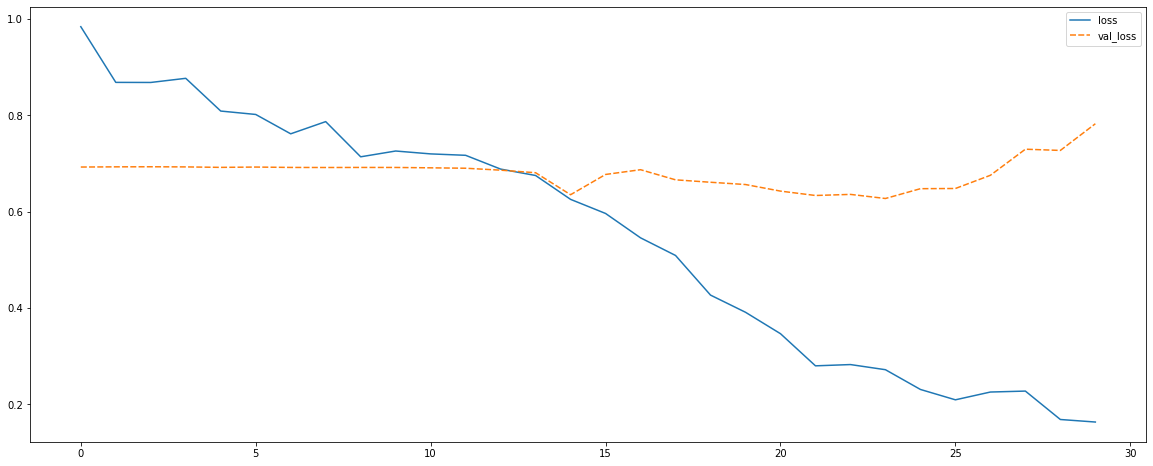

In [34]:
plt.figure(figsize=(20,8))

sns.lineplot(data=loss)

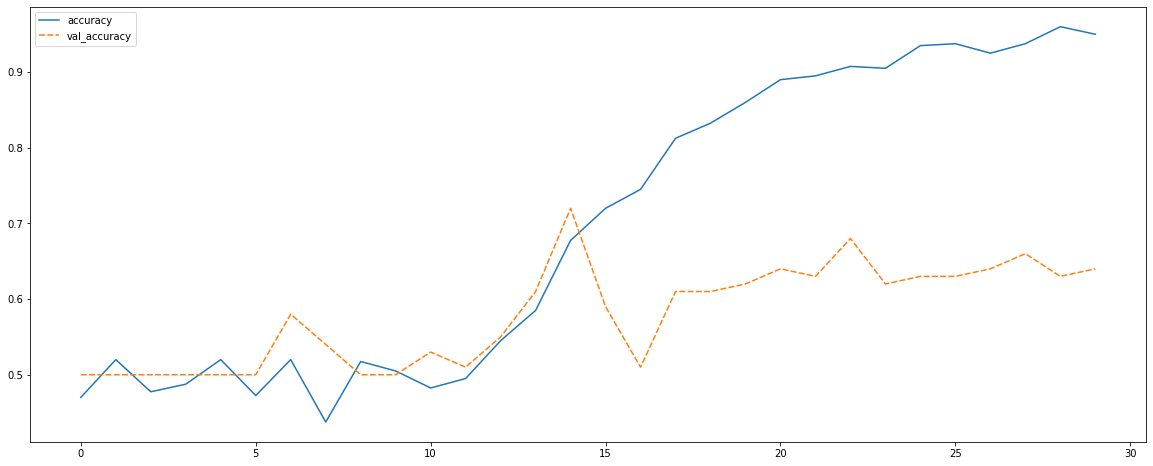

In [35]:
plt.figure(figsize=(20,8))

sns.lineplot(data=accuracy)

In [36]:
predict_model = load_model(filename)

In [37]:
score = predict_model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6274746656417847
Test accuracy: 0.6200000047683716


In [38]:
pred = np.argmax(model.predict(X_val), axis=-1)  # 0 means neg, 1 means pos
y_true = np.argmax(y_val,axis = 1)

Text(87.0, 0.5, 'Actual')

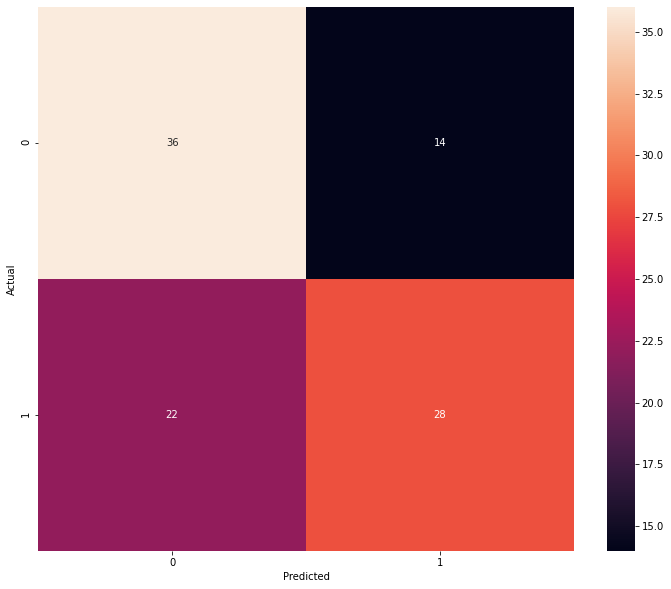

In [39]:
cm = confusion_matrix(y_true, pred)

plt.figure(figsize=(12, 10))

sns.heatmap(data=cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [40]:
label_dict = output_tokenizer.word_index
label = [key for key, value in label_dict.items()]

In [41]:
label = [key for key, value in label_dict.items()]

In [42]:
print(classification_report(y_true, pred, target_names=label, digits=4))


              precision    recall  f1-score   support

         neg     0.6207    0.7200    0.6667        50
         pos     0.6667    0.5600    0.6087        50

    accuracy                         0.6400       100
   macro avg     0.6437    0.6400    0.6377       100
weighted avg     0.6437    0.6400    0.6377       100



## Gensim

In [43]:
from gensim.models import Word2Vec

sentences = [st.split() for st in cleaned_words]

dimension = 128
w2v_model = Word2Vec(sentences, min_count=1, vector_size=dimension, workers=6, sg=1, epochs=1000)
w2v_model.save('w2v_model.bin')
new_model = Word2Vec.load('w2v_model.bin')

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning:

The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.



In [44]:
embedding_matrix = np.zeros((vocab_size, dimension))

for word, i in train_word_tokenizer.word_index.items():
    if word in new_model.wv.key_to_index:
        embedding_vector = new_model.wv[word]
        embedding_matrix[i] = embedding_vector

In [45]:
adam = Adam(lr=0.003)

def create_model(vocab_size, max_length):
  model = Sequential()
  
  model.add(Embedding(vocab_size, dimension, input_length = max_length, trainable = False, weights=[embedding_matrix]))
  model.add(Bidirectional(GRU(128, activation = "relu")))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.8))
  model.add(Dense(64, activation = "relu"))
  model.add(Dropout(0.8))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  
  return model
  
model = create_model(vocab_size, max_length)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [46]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 128)           105984    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               198144    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)               

In [47]:
filename = 'model.gensim.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [48]:
EPOCHS = 30
gensim_hist = model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val), callbacks = [checkpoint], verbose = 0)


Epoch 00001: val_loss improved from inf to 0.69931, saving model to model.gensim.h5

Epoch 00002: val_loss improved from 0.69931 to 0.69027, saving model to model.gensim.h5

Epoch 00003: val_loss improved from 0.69027 to 0.68758, saving model to model.gensim.h5

Epoch 00004: val_loss did not improve from 0.68758

Epoch 00005: val_loss improved from 0.68758 to 0.68631, saving model to model.gensim.h5

Epoch 00006: val_loss did not improve from 0.68631

Epoch 00007: val_loss did not improve from 0.68631

Epoch 00008: val_loss improved from 0.68631 to 0.68623, saving model to model.gensim.h5

Epoch 00009: val_loss improved from 0.68623 to 0.68554, saving model to model.gensim.h5

Epoch 00010: val_loss improved from 0.68554 to 0.68282, saving model to model.gensim.h5

Epoch 00011: val_loss did not improve from 0.68282

Epoch 00012: val_loss improved from 0.68282 to 0.67831, saving model to model.gensim.h5

Epoch 00013: val_loss improved from 0.67831 to 0.67501, saving model to model.gensi

In [49]:
predict_model = load_model(filename)
predict_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 128)           105984    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               198144    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)               

In [50]:
score = predict_model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6261888146400452
Test accuracy: 0.6800000071525574


In [51]:
with open('history_model.gensim', 'wb') as file:
    p.dump(gensim_hist.history, file)

In [52]:
with open('history_model.gensim', 'rb') as file:
    histgensim = p.load(file)

In [53]:
loss = {key : histgensim.get(key) for key in ('loss', 'val_loss')}
accuracy = {key : histgensim.get(key) for key in ('accuracy', 'val_accuracy')}

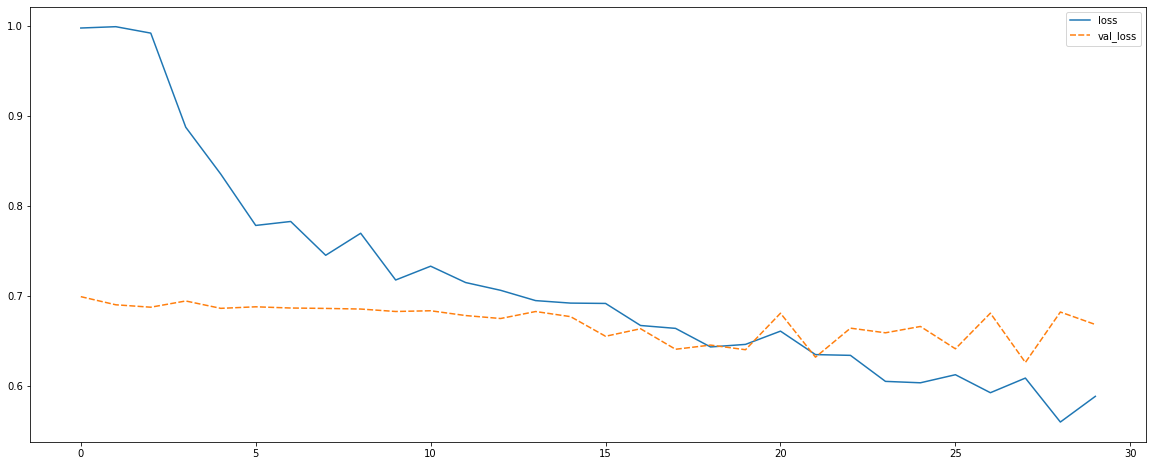

In [54]:
plt.figure(figsize=(20,8))

sns.lineplot(data=loss)

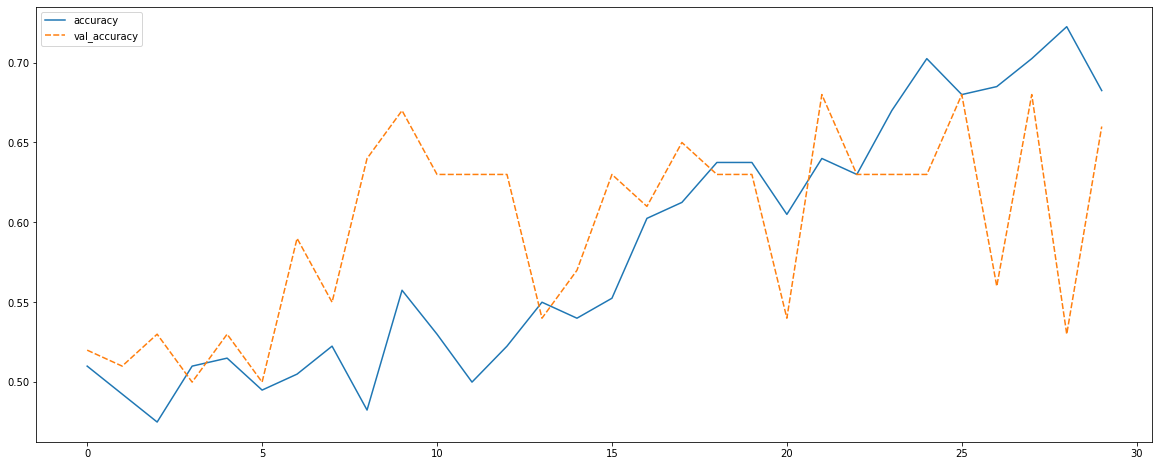

In [55]:
plt.figure(figsize=(20,8))

sns.lineplot(data=accuracy)

In [56]:
predict_model = load_model(filename)

In [57]:
score = predict_model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6261888146400452
Test accuracy: 0.6800000071525574


In [58]:
pred = np.argmax(predict_model.predict(X_val), axis=-1)  # 0 means neg, 1 means pos
y_true = np.argmax(y_val,axis = 1)

Text(87.0, 0.5, 'Actual')

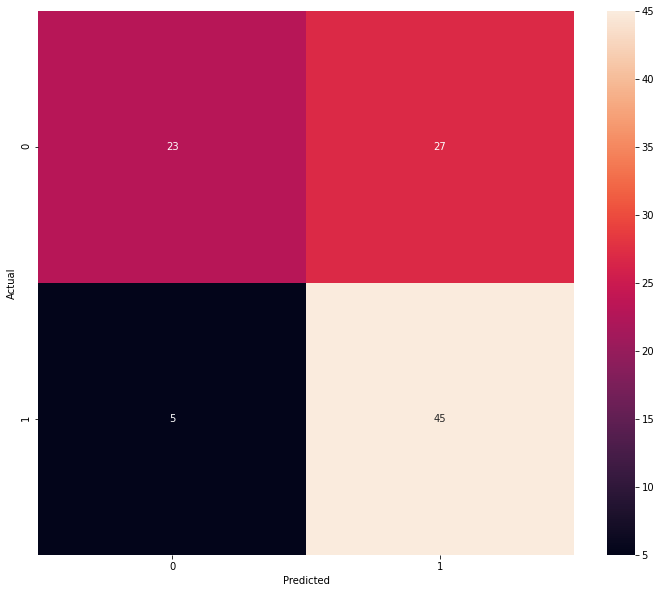

In [59]:
cm = confusion_matrix(y_true, pred)

plt.figure(figsize=(12, 10))

sns.heatmap(data=cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [60]:
label_dict = output_tokenizer.word_index
label = [key for key, value in label_dict.items()]

In [61]:
label = [key for key, value in label_dict.items()]

In [62]:
print(classification_report(y_true, pred, target_names=label, digits=4))


              precision    recall  f1-score   support

         neg     0.8214    0.4600    0.5897        50
         pos     0.6250    0.9000    0.7377        50

    accuracy                         0.6800       100
   macro avg     0.7232    0.6800    0.6637       100
weighted avg     0.7232    0.6800    0.6637       100

